In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# to interpolate
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import interp1d

import sys
sys.path.insert(1, '../Files')

import logo
from constants import Units, Constants
import SNprofiles
import ALPnucleonINT as ALPint

from ALPdetection import ALPphotonDET, ALPphotonDET_multi
from SNdistribution import SNdistribution

In [2]:
%load_ext autoreload
%autoreload 2

Check if everything is ok

In [3]:
logo.logo()


      ____  _   _   _____          _                 _\/_
     / ___|| \ | | |  ___|_ _  ___| |_ ___  _ __ _   _/\ 
     \___ \|  \| | | |_ / _` |/ __| __/ _ \| '__| | | |
      ___) | |\  | |  _| (_| | (__| || (_) | |  | |_| |
     |____/|_| \_| |_|  \__,_|\___|\__\___/|_|   \__, |
                                                 |___/ 
                                            
                Baking particles since 1987!
                         v.beta.1
    


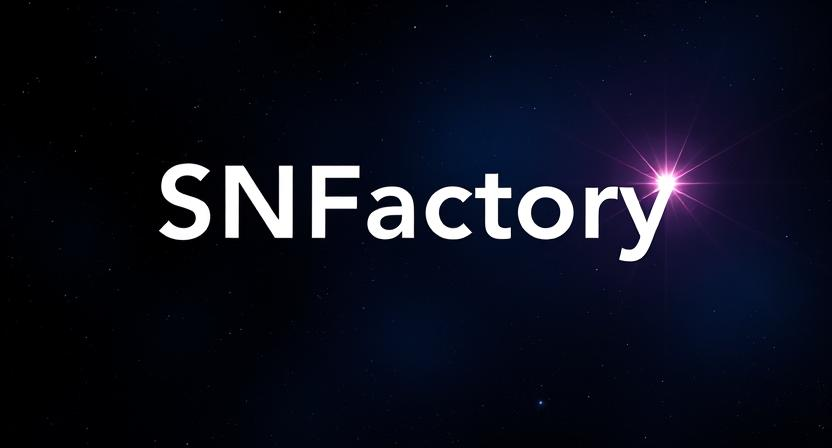

In [4]:
logo.logoIMG()

# 1. SN Profiles

In [6]:
# folder where the profiles are stored
dir_profiles = "../ConfigFiles/SN-profiles/18MsolProgenitor-AB/"

# profiles
rho_file = dir_profiles + "rho_PROF1.dat"
Ye_file = dir_profiles + "Ye_PROF1.dat"
T_file = dir_profiles + "T_PROF1.dat"
lapse_file = dir_profiles + "lapse_PROF1.dat"
mphoton_file = dir_profiles + "mphoton_PROF1.dat"
npeff_file = dir_profiles + "npeff_PROF1.dat"
echempot_file = dir_profiles + "echempot_PROF1.dat"
Ymu_file = dir_profiles + "Ymu_PROF1.dat"
Ypi_file = dir_profiles + "Ypi_VIR_PROF1.dat"


#####################
# LOAD THE PROFILES #
#####################
# if use_saved_lapse=True uses the data in the "lapse_file", if False computes it and saves it in "lapse_file"

SN_prof = SNprofiles.SNprofiles_QCDALP(rho_file, 
                                       Ye_file, 
                                       T_file, 
                                       mphoton_file, 
                                       npeff_file, 
                                       echempot_file, 
                                       Ymu_file, 
                                       Ypi_file, 
                                       use_saved_lapse=True, lapse_file=lapse_file)


# 2. ALP-nucleon interactions (KSVZ)

# 2.1. Bremsstrahlung

In [7]:
# folder where the NSF are stored
dir_NSF = "../ConfigFiles/SN-structurefunc/"

sx_file_KSVZ = dir_NSF + "sx_grid_KSVZ.dat"

NSF_KSVZ = ALPint.NuclStructFunc(Cap=-0.47, Can=0, profile=SN_prof, use_saved_sx=True, sx_file=sx_file_KSVZ)

In [8]:
brems_KSVZ = ALPint.ALP_Brems( profile=SN_prof, NuclStruct=NSF_KSVZ)

# 2.2 Pionic conversion

In [9]:
pion_KSVZ = ALPint.ALP_Pion(Cap=-0.47, Can=0, profile=SN_prof )

# 2.3 Photo-production   $\gamma$ p $\rightarrow$ p a

In [10]:
ALPphoton_KSVZ = ALPint.ALP_Photon( Cap=-0.47, profile=SN_prof)

# 2.4 Dipole interaction

In [11]:
ALPdipole = ALPint.ALP_Dipole( Capgamma=-0.0033, Cangamma=0.0033, profile=SN_prof)

# 3. Production and Absoption

In [12]:
# only bremsstrahlung and pionic conversion

production = [brems_KSVZ.dndEdt,
              pion_KSVZ.dndEdt]
absorption = [brems_KSVZ.lambdaam1,  
              pion_KSVZ.lambdaam1]

generator_KSVZ = ALPint.SN_particle_generator( profile=SN_prof, lambdaam1_all=absorption, dndEdt_all=production)

# 4. Detection in Super-Kamiokande

## Signal

Consider the process $ a p \rightarrow \gamma p$ in water Cherenkov detectors

<img src="imgs/detection-photoproduction.png" alt="detection" width="700">

## Photon spectra: number of photons per energy and time


<img src="imgs/photon-spectra-SK.png" alt="photon-spectra-SK" width="450">

with 
- $\frac{d\Phi_a}{d E_a^{Earth}}$ the ALP flux at Earth,
- $\frac{d\sigma_{ap}}{dE_{\gamma}}$ the $a p \rightarrow \gamma p$ cross-section,
- $N_t$ the number of targets,
- $E_a^{min}$, $E_a^{max}$ the min and max ALP energy that produces a photon with energy $E_{\gamma}$.

D. Alonso-González, D. Cerdeño, M. Cermeño and A.D. Perez, Probing a diffuse flux of axion-like particles from galactic supernovae with neutrino water Cherenkov detectors, Phys.Rev.D 111 (2025) 8, 083019, Phys.Rev.D 112 (2025) 2, 029901 (erratum) [2412.09595]

## 4.1 Diffuse flux from galactic SN

Here we are going to compute the diffuse flux factor that is going to multiply the flux of a single SN.

We are assuming that all SN produce the same spectrum, and integrating the contribution of all past galactic SN.

----------------------
Galactic SN distribution:
<img src="imgs/SNdistribution.png" alt="SNdistribution" width="250">

---------------------------
Diffuse flux:

<img src="imgs/flux-factor.png" alt="flux-factor" width="600">

with $\frac{dN_a}{dE_a^{Earth}}$ the ALP spectrum at Earth of a single SN.

D. Alonso-González, D. Cerdeño, M. Cermeño and A.D. Perez, Probing a diffuse flux of axion-like particles from galactic supernovae with neutrino water Cherenkov detectors, Phys.Rev.D 111 (2025) 8, 083019, Phys.Rev.D 112 (2025) 2, 029901 (erratum) [2412.09595]

----------------------

For that you have class $\bf{SNdistribution}$ defined in the imported module $\bf{SNdistribution}$

Inputs:
- SNrate: galactic SN rate [number of SN events per century]
- Rd: exponential radial parameter [kpc]
- H: exponential z parameter [kpc]
- RE: r positon of the Earth wrt the Galactic Center [kpc]
- zE: z position of the Earth wrt the Galactic plane [kpc]

In [14]:
SNdist = SNdistribution(SNrate=1.63, 
                        Rd=2.6, 
                        H=0.3, 
                        RE=8.7, 
                        zE=0.024)

The function $\bf{flux\_factor}$ inside the class $\bf{SNdistribution}$ computes the flux factor

In [206]:
# RE = 8.7
diffSNfactor = SNdist.flux_factor()
print("diffuse galactic SN flux factor: ", diffSNfactor, " [cm^{-2} s^{-1}]")

/home/andres/CompuTools/Trabajos/Direct-Detection/Supernovas/SN-and-ALPs/03-SN-ALP-program/Files/SNdistribution.py:75: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  F_vals[i, j], _ = quad(flux_theta_integrand, 0, 2*np.pi, args=(r_vals[i], z_vals[j]), epsabs=1e-3, epsrel=1e-3)


diffuse galactic SN flux factor:  1.3056931295139403e-55  [cm^{-2} s^{-1}]


In [15]:
SNdist = SNdistribution(SNrate=1.63, 
                        Rd=2.6, 
                        H=0.3, 
                        RE=8.23, 
                        zE=0.024)

In [16]:
# RE = 8.23
diffSNfactor = SNdist.flux_factor()
print("diffuse galactic SN flux factor: ", diffSNfactor, " [cm^{-2} s^{-1}]")

diffuse galactic SN flux factor:  1.3954660913718083e-55  [cm^{-2} s^{-1}]


## 4.2 Cross-section and significance

The class $\bf{ALPphotonDET}$ defined in the imported module $\bf{ALPdetection}$ is used to compute the Exclusion significance.

Inputs:
- Cap: to define the model (note that only the ALP-proton coupling is relevant for detection)
- Deltat: time window [s] where the SN is producing ALPs (assuming that the spectrum is the same as in t=1 s after bounce)
- diffSNfactor: the flux factor that multiplies the flux of a single SN to account for the contribution of all past galactic SN [cm$^{-2}$ s$^{-1}$]

In [17]:
Deltat=1.5 # s
# Deltat=np.log(10) # s

apgp_KSVZ = ALPphotonDET( Cap=-0.47, Deltat=Deltat, diffSNfactor=diffSNfactor )

### 4.2.1 Max and min $E_{\gamma}$, $E_a$

Using the functions in the class $\bf{ALPphotonDET}$, we can compute the $E_{\gamma}$ min and max that would be produced by and ALP of energy $E_a$.

Notice that $E_{\gamma} \sim E_a$

In [18]:
# Egamma Range
Egamma_min = apgp_KSVZ.E_gamma_min(Ea=30, ma=20)
Egamma_max = apgp_KSVZ.E_gamma_max(Ea=30, ma=20)

print('For E_a = 30 MeV and m_a = 20 MeV:')
print('$E_{\gamma}^{min} = $', Egamma_min, '[MeV]')
print('$E_{\gamma}^{max} = $', Egamma_max, '[MeV]')

For E_a = 30 MeV and m_a = 20 MeV:
$E_{\gamma}^{min} = $ 28.615837218455223 [MeV]
$E_{\gamma}^{max} = $ 29.96914298493519 [MeV]


Or compute the $E_a$ min and max that would result in a photon of energy $E_{\gamma}$

In [19]:
# Egamma Range
Eamin = apgp_KSVZ.Eamin(Egamma=30, ma=20)
Eamax = apgp_KSVZ.Eamax(Egamma=30, ma=20)

print('For E_{\gamma} = 30 MeV and m_a = 20 MeV:')
print('$E_a^{min} = $', Eamin, '[MeV]')
print('$E_a^{max} = $', Eamax, '[MeV]')

For E_{\gamma} = 30 MeV and m_a = 20 MeV:
$E_a^{min} = $ 30.03077262103312 [MeV]
$E_a^{max} = $ 31.57833122517677 [MeV]


### 4.2.2 Cross-section

Using the function is the class $\bf{ALPphotonDET}$, we can compute and plot the cross-section for an example.

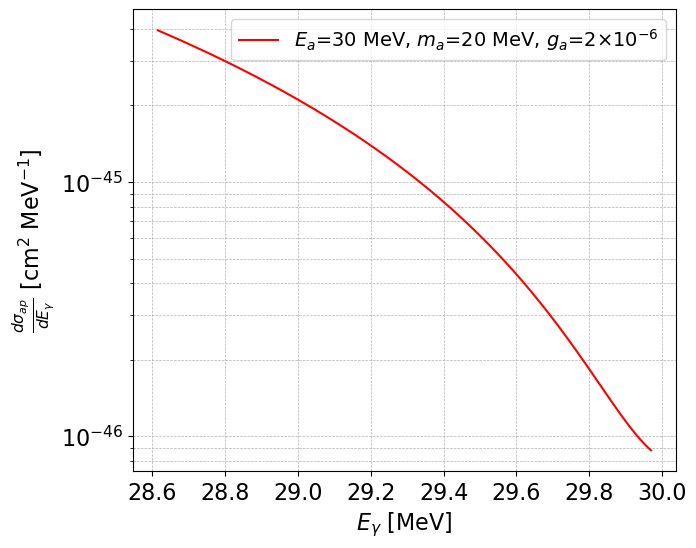

In [20]:
Egamma_vals = np.linspace(Egamma_min, Egamma_max, 500)

# Compute dσ/dEγ
sigma_vals = [Units.cmminus1toMeV**(2) * apgp_KSVZ.dSigma_dEgamma(E, Ea=30, ma=20, ga=2e-6) for E in Egamma_vals]

# Plot
plt.figure(figsize=(7,6))
plt.plot(Egamma_vals, sigma_vals, label=r'$E_a$=30 MeV, $m_a$=20 MeV, $g_a$=2$\times 10^{-6}$', color='r')

plt.yscale("log")
# plt.ylim(1e-25,2e-23)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
# plt.title("Differential cross section", fontsize=14)
plt.xlabel(r'$E_{\gamma}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{d\sigma_{ap}}{dE_{\gamma}}$ [cm$^{2}$ MeV$^{-1}$]', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### 4.2.3 Photon spectra $\frac{dN_{\gamma}}{dE_{\gamma}}$

<img src="imgs/photon-spectra-SK.png" alt="photon-spectra-SK" width="450">

--------------

The function $\bf{dNgammadEgamma}$ inside the class $\bf{ALPphotonDET}$ computes the photon spectra

$\hspace{1cm}$ apgp_KSVZ.dNgammadEgamma(Egamma, ma, ga, dNdEdt)

Inputs:
- Egamma: energy of the outgoing photon
- ma: mass of the incoming ALP
- ga: ALP coupling strength
- dNdEdt: dN_a^2 / (dE_a dt)   ---> this is the number of ALPs per ALPs energy and time generated by a single SN


dNdEdt $\bf{needs}$ to be a function with 3 arguments: dNdEdt(Ea, ma, ga)

-------------------
As we will see, computing $\bf{dNgammadEgamma}$ takes a long time because computing $\bf{dNdEdt}$ is expensive.

So, we have 2 options:
- compute dN^2/dEdt during the computation of the photon spectra
- compute a grid of dN^2/dEdt, save it, and use an interpolation

#### OPTION 1: Compute dN^2/dEdt during the computation of dNgammadEgamma (expensive)

Use as input: dNdEdt=generator_KSVZ.dNdEdt

with

generator_KSVZ = ALPint.SN_particle_generator( profile=SN_prof, lambdaam1_all=absorption, dndEdt_all=production)

In [21]:
maTEST = 10 # MeV
gaTEST = 3.16764e-06

In [ ]:
# TAKES A LOT OF TIMES IF YOU WANT A SCAN!

start_time = time.time()

result = apgp_KSVZ.dNgammadEgamma(Egamma=50, ma=maTEST, ga=gaTEST, dNdEdt=generator_KSVZ.dNdEdt )

print(" for Nt=1 ")
print("dNgamma^2/dEgamma dt = ", Units.stoMeVminus1 * result , " [MeV^{-1} s^{-1}]")
print("--- %s seconds ---" % (time.time() - start_time))

#### OPTION 2-A: Use an interpolation dN^2/dEdt to compute dNgammadEgamma (recomended option for new models)

In [23]:
start_time = time.time()
print( generator_KSVZ.dNdEdt(15, ma=maTEST, ga=gaTEST) )
print("--- %s seconds ---" % (time.time() - start_time))

3.3762714834128064e+34
--- 189.04257035255432 seconds ---


In [23]:
# let's interpolate dNdEdt to make it faster

Ea_list = np.linspace(11, 150, 20) # MeV

dNdEdt_aux = [ generator_KSVZ.dNdEdt(Ea, ma=maTEST, ga=gaTEST).tolist() for Ea in Ea_list ]

In [24]:
dNdEdt_aux

[1.59201880836283e+34,
 3.623302299094906e+34,
 2.8215442731662073e+34,
 1.7615512950168117e+34,
 9.945103732651157e+33,
 5.335819686593229e+33,
 2.783287470652799e+33,
 1.4364543932196918e+33,
 7.428865346091155e+32,
 3.8518259052359666e+32,
 2.0295640988351277e+32,
 1.0870469469579333e+32,
 5.944041454147961e+31,
 3.3225325476252928e+31,
 1.9021096093163426e+31,
 1.1169053503093848e+31,
 6.728761236519579e+30,
 6.140756482829352e+30,
 3.231183697660756e+28,
 5.720709000619967e+27]

In [24]:
dNdEdt_aux = [1.59201880836283e+34, 3.623302299094906e+34, 2.8215442731662073e+34, 1.7615512950168117e+34, 9.945103732651157e+33, 5.335819686593229e+33, 2.783287470652799e+33, 1.4364543932196918e+33, 7.428865346091155e+32, 3.8518259052359666e+32, 2.0295640988351277e+32, 1.0870469469579333e+32, 5.944041454147961e+31, 3.3225325476252928e+31, 1.9021096093163426e+31, 1.1169053503093848e+31, 6.728761236519579e+30, 6.140756482829352e+30, 3.231183697660756e+28, 5.720709000619967e+27]

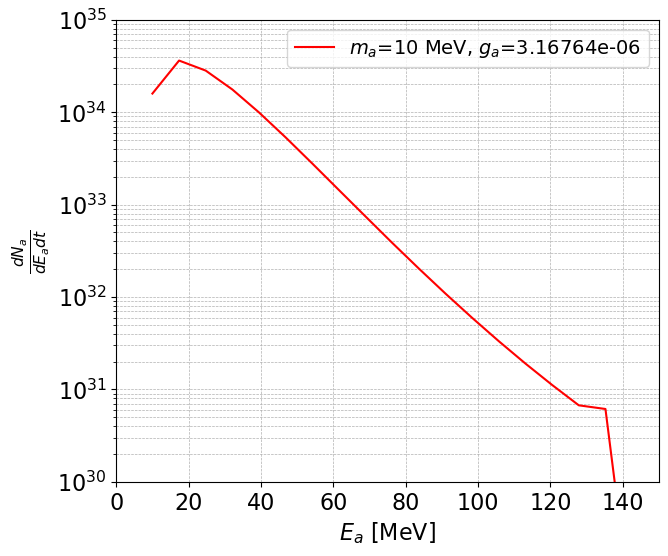

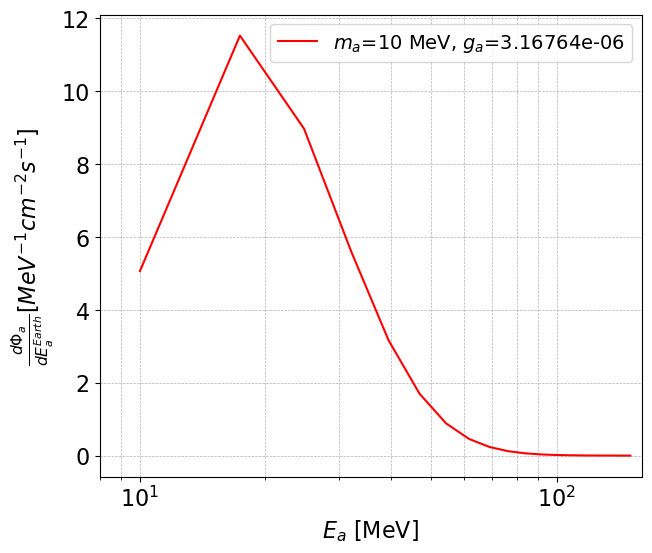

In [25]:
# INTERPOLATE

Ea_list = np.linspace(10, 150, 20) # MeV

# THE INTERPOLATED FUNCTION dNdEdt REQUIRES 3 ARGUMENTS
# last 2 arguments are dummies
def dNdEdt_interpol(Ea, ma=None, ga=None):
    auxF = interp1d(Ea_list, dNdEdt_aux, kind='linear', fill_value="extrapolate")
    return auxF(Ea)


dNdEdt_plt = [dNdEdt_interpol(EE) for EE in Ea_list]
fluxdEa_plt = [diffSNfactor * Deltat * Units.stoMeVminus1 * dNdEdt_interpol(EE) for EE in Ea_list]


# Plot
plt.figure(figsize=(7,6))
plt.plot(Ea_list, dNdEdt_plt, label=fr'$m_a$={maTEST} MeV, $g_a$={gaTEST}', color='r')

plt.yscale("log")
plt.ylim(1e30,1e35)
plt.xlim(0,150)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel(r'$E_{a}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{dN_a}{dE_adt}$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()




# Plot
plt.figure(figsize=(7,6))
plt.plot(Ea_list, fluxdEa_plt, label=fr'$m_a$={maTEST} MeV, $g_a$={gaTEST}', color='r')

plt.xscale("log")
# plt.yscale("log")
# plt.ylim(1e30,1e35)
plt.xlim(8,160)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel(r'$E_{a}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{d\Phi_a}{dE_a^{Earth}} [MeV^{-1} cm^{-2} s^{-1}]$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [26]:
# time with the interpolation

start_time = time.time()

result = apgp_KSVZ.dNgammadEgamma(Egamma=50, ma=maTEST, ga=gaTEST, dNdEdt=dNdEdt_interpol )

print(" for Nt=1 ")
print("dNgamma^2/dEgamma dt = ", Units.stoMeVminus1 * result , " [MeV^{-1} s^{-1}]")
print("--- %s seconds ---" % (time.time() - start_time))

 for Nt=1 
dNgamma^2/dEgamma dt =  1.3290576957398969e-44  [MeV^{-1} s^{-1}]
--- 0.005490541458129883 seconds ---


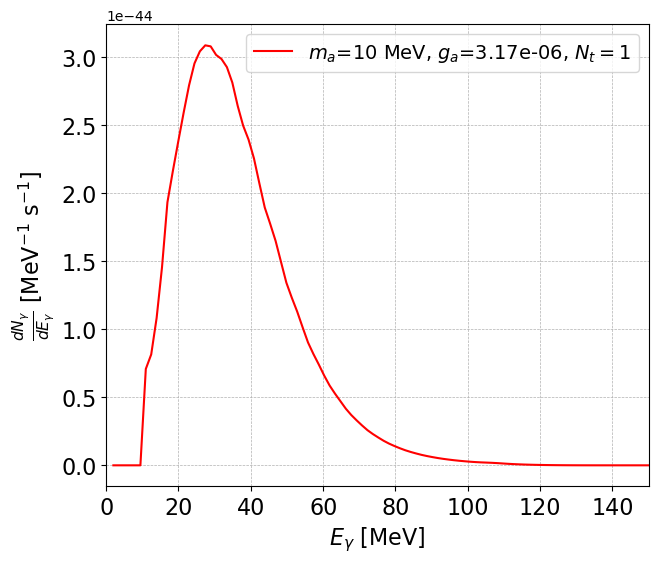

In [27]:
# Egamma Range
Egamma_vals = np.linspace(2, 150, 100)

# Compute dσ/dEγ
dNgammadEgamma_vals = [Units.stoMeVminus1 * 
                       apgp_KSVZ.dNgammadEgamma(E, ma=maTEST, ga=gaTEST, dNdEdt=dNdEdt_interpol ) 
                       for E in Egamma_vals]

# Plot
plt.figure(figsize=(7,6))
plt.plot(Egamma_vals, dNgammadEgamma_vals, label=fr'$m_a$={maTEST} MeV, $g_a$={gaTEST:.3g}, $N_t=1$', color='r')

# plt.yscale("log")
plt.xlim(0,150)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel(r'$E_{\gamma}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{dN_{\gamma}}{dE_{\gamma}}$ [MeV$^{-1}$ s$^{-1}$]', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

#### OPTION 2-B: Use an interpolation dN^2/dEdt  (recomended for this model, a grid of dNdEdt pre-saved)

In [28]:
# load
data = np.loadtxt("tutorial_results/dNdEdt_KSVZ.dat", delimiter=" ")

# columns
ga_vals, ma_vals, Ea_vals, dNdEdt_vals = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

# unique values of ga
unique_ga = np.unique(ga_vals)
unique_ga

array([2.00000e-06, 3.16764e-06, 5.01697e-06, 7.94597e-06, 1.25850e-05,
       1.99324e-05, 3.15693e-05, 5.00000e-05, 6.00000e-05, 7.00000e-05,
       8.00000e-05, 9.00000e-05, 1.00000e-04, 2.00000e-04, 3.00000e-04,
       4.00000e-04, 5.00000e-04])

selected ga = 3.16764e-06


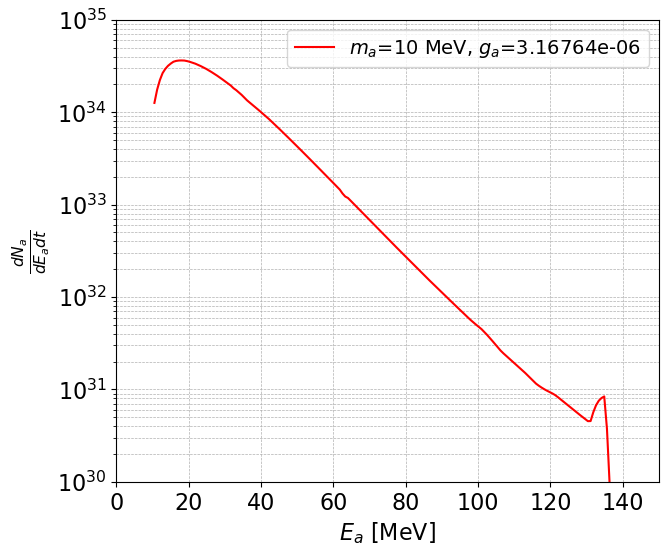

In [29]:
# select a single ga
gaTEST = unique_ga[1]
print("selected ga =", gaTEST)

# create a mask to keep only the grid points with the selected ga value
mask = (ga_vals == gaTEST)

ma_subset = ma_vals[mask]
Ea_subset = Ea_vals[mask]
dNdEdt_subset = dNdEdt_vals[mask]




# Interpolate
dNdEdt_interpol = LinearNDInterpolator(list(zip(Ea_subset, ma_subset)), dNdEdt_subset)

# evaluate
Ea_plt = np.linspace(0, 150, 200) # MeV

maTEST = 10 # MeV
dNdEdt_plt = dNdEdt_interpol(Ea_plt, maTEST)


# Plot
plt.figure(figsize=(7,6))
plt.plot(Ea_plt, dNdEdt_plt, label=fr'$m_a$={maTEST} MeV, $g_a$={gaTEST}', color='r')

plt.yscale("log")
plt.ylim(1e30,1e35)
plt.xlim(0,150)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel(r'$E_{a}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{dN_a}{dE_adt}$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [30]:
# last 2 arguments are dummies
# we need this because dNdEdt needs 3 variables (to be able to be used without a pre-saved grid)
def dNdEdt_aux(Ea, ma=None, ga=None):
    auxF = lambda Ea: dNdEdt_interpol(Ea, maTEST)
    return auxF(Ea)


start_time = time.time()

result = apgp_KSVZ.dNgammadEgamma(Egamma=50, ma=maTEST, ga=gaTEST, dNdEdt=dNdEdt_aux )

print(" for Nt=1 ")
print("dNgamma^2/dEgamma dt = ", Units.stoMeVminus1 * result , " [MeV^{-1} s^{-1}]")
print("--- %s seconds ---" % (time.time() - start_time))

 for Nt=1 
dNgamma^2/dEgamma dt =  1.364398611372029e-44  [MeV^{-1} s^{-1}]
--- 0.0021576881408691406 seconds ---


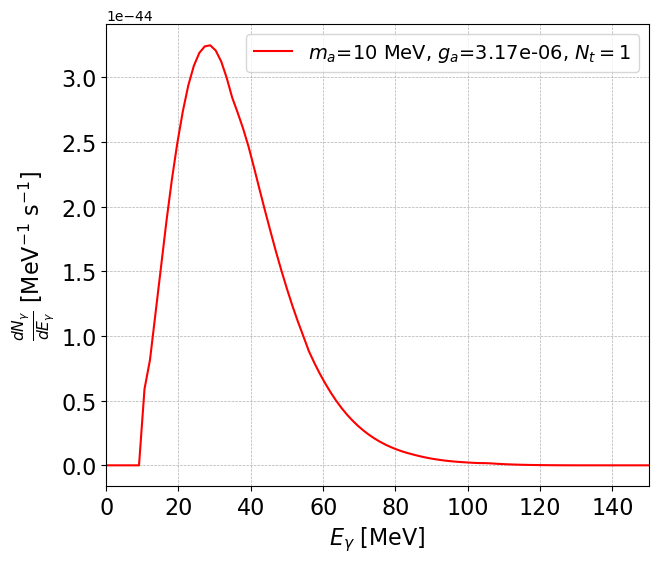

In [31]:
# Egamma Range
Egamma_vals = np.linspace(0, 150, 100)

# Compute dσ/dEγ
dNgammadEgamma_vals = [Units.stoMeVminus1 * 
                       apgp_KSVZ.dNgammadEgamma(E, ma=maTEST, ga=gaTEST, dNdEdt=dNdEdt_aux ) 
                       for E in Egamma_vals]


# Plot
plt.figure(figsize=(7,6))
plt.plot(Egamma_vals, dNgammadEgamma_vals, label=fr'$m_a$={maTEST} MeV, $g_a$={gaTEST:.3g}, $N_t=1$', color='r')

# plt.yscale("log")
plt.xlim(0,150)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xlabel(r'$E_{\gamma}$ [MeV]', fontsize=16)
plt.ylabel(r'$\frac{dN_{\gamma}}{dE_{\gamma}}$ [MeV$^{-1}$ s$^{-1}$]', fontsize=16)
plt.legend(loc="upper right",fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

## 4.3 DATA: load SK IV expected and observed events

In [34]:
# Super Kamiokande phase IV:
NtSK = 10**9 * 2 * 6.022 * 10**23 * 22.5 / 18  # Number of targets
exptSKIV = 2970*24*60*60 # 2970 days = 8.13 years



# Load SKIV data (assuming tab-separated values)
SKIV_data = pd.read_csv("../ExpData/SK/SKIV.txt", sep='\s+')# delim_whitespace=True)#, header=None)




# Define energy bins
bins_SKIV = np.arange(16, 80, 2)

# Measured background (Poissonian error)
Nobs_SKIV = np.array([(SKIV_data.iloc[i, 0], SKIV_data.iloc[i, 1]) for i in range(1, len(SKIV_data) - 2)])

# Expected total background INCLUDING DSNB model
Bth_SKIV = np.array([(SKIV_data.iloc[i, 0], SKIV_data.iloc[i, 2] + SKIV_data.iloc[i, 3]) for i in range(1, len(SKIV_data) - 2)])


ga =  0.0002
ma =  30


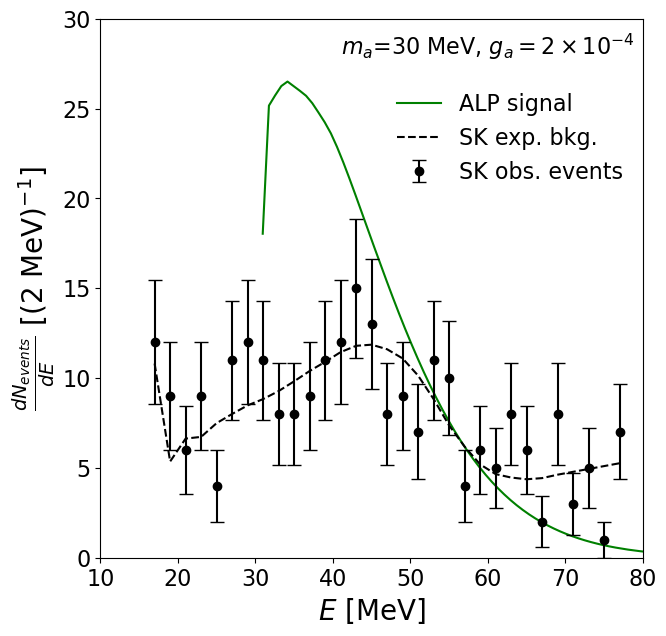

In [39]:
# EXPECTED SIGNAL IN THE DETECTOR

# select a ga and ma
gaTEST = unique_ga[13]
maTEST = 30 # MeV

print("ga = ", gaTEST)
print("ma = ", maTEST)


# create a mask to keep only the grid points with the selected ga value
mask = (ga_vals == gaTEST)

ma_subset = ma_vals[mask]
Ea_subset = Ea_vals[mask]
dNdEdt_subset = dNdEdt_vals[mask]

# Interpolate
dNdEdt_interpol = LinearNDInterpolator(list(zip(Ea_subset, ma_subset)), dNdEdt_subset)



# Create the function (last 2 arguments are dummies)
# we need this because dNdEdt needs 3 variables (to be able to be used without a pre-saved grid)
def dNdEdt_aux(Ea, ma=None, ga=None):
    auxF = lambda Ea: dNdEdt_interpol(Ea, maTEST)
    return auxF(Ea)



# PLOT THE EXPECTED SIGNAL
# Egamma Range
Egamma_vals = np.linspace(30.95, 150, 150)

# Compute dσ/dEγ
dNgammadEgamma_vals = [2* NtSK * exptSKIV * 
                       Units.stoMeVminus1 * 
                       apgp_KSVZ.dNgammadEgamma(E, ma=maTEST, ga=gaTEST, dNdEdt=dNdEdt_aux ) 
                       for E in Egamma_vals]



# Plot
plt.figure(figsize=(7,7))

plt.plot(Egamma_vals, dNgammadEgamma_vals, label=fr'ALP signal', color='green')
plt.plot(Bth_SKIV[:,0], Bth_SKIV[:,1], c="black", ls="--", label=r"SK exp. bkg.")
plt.errorbar(Nobs_SKIV[:,0], Nobs_SKIV[:,1], yerr=Nobs_SKIV[:,1]**0.5, fmt='o', color='black', ecolor='black', capsize=5, label='SK obs. events')

plt.text(60, 28, r'$m_a$=30 MeV, $g_a=2\times 10^{-4}$', color='black', fontsize=16, rotation=0, ha='center')

# plt.yscale("log")
plt.xlim(10,80)
plt.ylim(0,30)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
# plt.title(" SK-IV ", fontsize=16)
plt.xlabel(r'$E$ [MeV]', fontsize=20)
plt.ylabel(r'$\frac{dN_{events}}{dE}$ [(2 MeV)$^{-1}$]', fontsize=20)
plt.legend(frameon=False, loc="upper right",bbox_to_anchor=(1, 0.9), fontsize=16)
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig("tutorial_results/dNeventsdE_vs_E_ma_30MeV.pdf", bbox_inches='tight')
plt.show()

### Significance

The function $\bf{Zthobs}$ inside the class $\bf{ALPphotonDET}$ computes the significance

Inputs:
- ma: axion mass,
- ga: axion coupling,
- dNdEdt: ALP spectrum generated by a single SN as a function of Ea, ma, ga (internally computes dNgammadEgamma[Ea, ma, ga]),
- Ntargets: number of targets in the detector,
- exptime: exposure time of the considered experimental RUN, in seconds,
- bins: list of energy bins,
- Bth: number of EXPECTED background events per bin,
- Nobs: number of OBSERVED events per bin 

#### For a benchmark point

In [41]:
start_time = time.time()
result = apgp_KSVZ.Zthobs(maTEST, gaTEST/2, dNdEdt_aux, NtSK, exptSKIV, bins_SKIV, Bth_SKIV, Nobs_SKIV)
end_time = time.time()

print("Execution Time:", end_time - start_time, "seconds")
print("Z Value:", result)

Execution Time: 0.6550045013427734 seconds
Z Value: [np.float64(2.3428563194184586)]


#### For a grid (TAKES TIME, already saved)

In [41]:
with open("tutorial_results/Z_KSVZ_diffuse_4pi.txt", "w") as f:
    f.write("# m_a[MeV] g_a Z\n")  # Header
    

ma_plt = np.logspace(0, 2, 100)
    
# Loop (ga, ma)
for j, ga_j in enumerate(unique_ga):  # Index j for ga
    print("Working on ga: ", ga_j)
    
    mask = (ga_vals == ga_j)
    
    ma_subset = ma_vals[mask]
    Ea_subset = Ea_vals[mask]
    dNdEdt_subset = dNdEdt_vals[mask]
    
    
    # Interpolate
    dNdEdt_interpol = LinearNDInterpolator(list(zip(Ea_subset, ma_subset)), dNdEdt_subset)
    
    
    for i, ma_i in enumerate(ma_plt):  # Index i for ma
        
        # last 2 arguments are dummies
        def dNdEdt_aux(Ea, ma=None, ga=None):
            auxF = lambda Ea: dNdEdt_interpol(Ea, ma_i)
            return auxF(Ea)
        
        
        # Evaluate Zthobs and store in Z_value
        Z_value = apgp_KSVZ.Zthobs(ma_i, ga_j, dNdEdt_aux, NtSK, exptSKIV, bins_SKIV, Bth_SKIV, Nobs_SKIV)[0]

        # Append result to file
        with open("tutorial_results/Z_KSVZ_diffuse_4pi.txt", "a") as f:
            f.write(f"{ma_i} {ga_j} {Z_value}\n")

print("\nDONE")

Working on ga:  2e-06
Working on ga:  3.16764e-06
Working on ga:  5.01697e-06
Working on ga:  7.94597e-06
Working on ga:  1.2585e-05
Working on ga:  1.99324e-05
Working on ga:  3.15693e-05
Working on ga:  5e-05
Working on ga:  6e-05
Working on ga:  7e-05
Working on ga:  8e-05
Working on ga:  9e-05
Working on ga:  0.0001
Working on ga:  0.0002
Working on ga:  0.0003
Working on ga:  0.0004
Working on ga:  0.0005

DONE


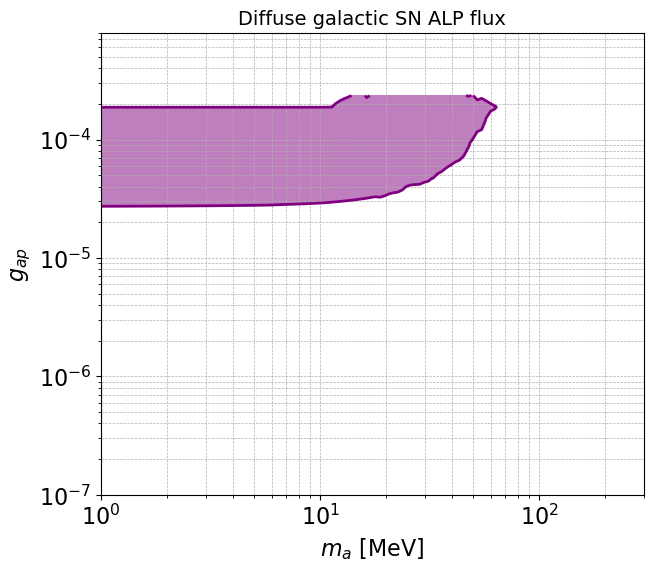

In [43]:

########
# Load #
########

data = np.loadtxt("tutorial_results/Z_KSVZ_diffuse_4pi.txt")
X_loaded, Y_loaded, Z_loaded = data[:, 0], data[:, 1], data[:, 2]

# g_ap = C_ap * g_a
Y_loaded = Y_loaded *0.47


# make the mesh
x_unique = np.unique(X_loaded)
y_unique = np.unique(Y_loaded)

X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

Z_grid = np.zeros_like(X_grid)

# Z values
for i in range(len(X_loaded)):
    x_idx = np.where(x_unique == X_loaded[i])[0][0]
    y_idx = np.where(y_unique == Y_loaded[i])[0][0]
    Z_grid[y_idx, x_idx] = Z_loaded[i]

    
    

Z_level = 1.64
threshold = Z_level

# Plot
plt.figure(figsize=(7,6))

plt.contour(X_grid, Y_grid, Z_grid, levels=[threshold], colors='purple', linewidths=2, linestyles='-')
plt.contourf(X_grid, Y_grid, Z_grid, levels=[threshold, Z_loaded.max()], colors=["purple"], alpha=0.5)

plt.xlim(1,3e2)
plt.ylim(1e-7,8e-4)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title("Diffuse galactic SN ALP flux", fontsize= 14)
plt.xlabel(r"$m_a$ [MeV]", fontsize= 16)
plt.ylabel(r"$g_{ap}$", fontsize= 16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

###### as a single bin

In [44]:
Bth_SKIV_new = np.array( [[ np.mean(Bth_SKIV[:,0]) , sum(Bth_SKIV[:,1]) ]] )
Nobs_SKIV_new = np.array( [[ np.mean(Nobs_SKIV[:,0]) , sum(Nobs_SKIV[:,1]) ]] )

In [45]:
start_time = time.time()
result = apgp_KSVZ.Zthobs(maTEST, gaTEST, dNdEdt_aux, NtSK, exptSKIV, [16,78], Bth_SKIV_new, Nobs_SKIV_new )
end_time = time.time()

print("Execution Time:", end_time - start_time, "seconds")
print("Z Values:", result)

Execution Time: 0.001149892807006836 seconds
Z Values: [np.float64(0.1428921718024625)]


#### For a grid

In [46]:
with open("tutorial_results/Z_KSVZ_diffuse_4pi_1bin.txt", "w") as f:
    f.write("# m_a[MeV] g_a Z\n")  # Header
    

ma_plt = np.logspace(0, 2, 100)
    
# Loop (ga, ma)
for j, ga_j in enumerate(unique_ga):  # Index j for ga
    print("Working on ga: ", ga_j)
    
    mask = (ga_vals == ga_j)
    
    ma_subset = ma_vals[mask]
    Ea_subset = Ea_vals[mask]
    dNdEdt_subset = dNdEdt_vals[mask]
    
    
    # Interpolate
    dNdEdt_interpol = LinearNDInterpolator(list(zip(Ea_subset, ma_subset)), dNdEdt_subset)
    
    
    for i, ma_i in enumerate(ma_plt):  # Index i for ma
        
        # last 2 arguments are dummies
        def dNdEdt_aux(Ea, ma=None, ga=None):
            auxF = lambda Ea: dNdEdt_interpol(Ea, ma_i)
            return auxF(Ea)
        
        
        # Evaluate Zthobs and store in Z_value
        Z_value = apgp_KSVZ.Zthobs(ma_i, ga_j, dNdEdt_aux, NtSK, exptSKIV, [16,78], Bth_SKIV_new, Nobs_SKIV_new )[0]

        # Append result to file
        with open("tutorial_results/Z_KSVZ_diffuse_4pi_1bin.txt", "a") as f:
            f.write(f"{ma_i} {ga_j} {Z_value}\n")

print("\nDONE")

Working on ga:  2e-06
Working on ga:  3.16764e-06
Working on ga:  5.01697e-06
Working on ga:  7.94597e-06
Working on ga:  1.2585e-05
Working on ga:  1.99324e-05
Working on ga:  3.15693e-05
Working on ga:  5e-05
Working on ga:  6e-05
Working on ga:  7e-05
Working on ga:  8e-05
Working on ga:  9e-05
Working on ga:  0.0001
Working on ga:  0.0002
Working on ga:  0.0003
Working on ga:  0.0004
Working on ga:  0.0005

DONE


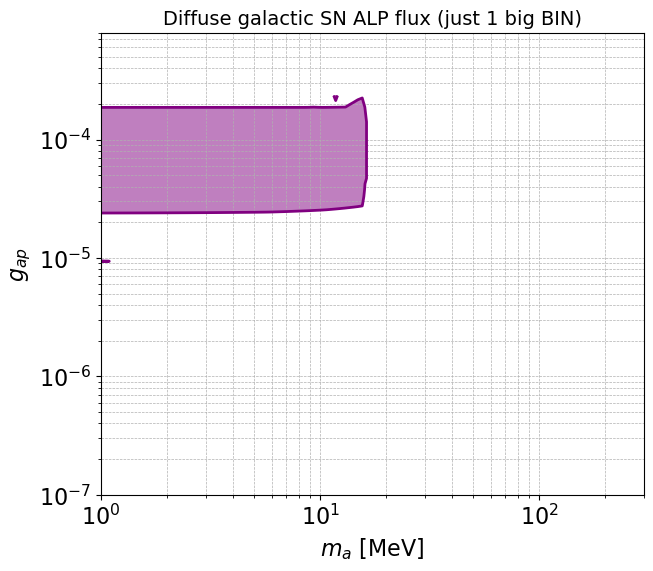

In [48]:
# load
data = np.loadtxt("tutorial_results/Z_KSVZ_diffuse_4pi_1bin.txt")
X_loaded, Y_loaded, Z_loaded = data[:, 0], data[:, 1], data[:, 2]

# g_ap = C_ap * g_a
Y_loaded = Y_loaded *0.47


# make the mesh
x_unique = np.unique(X_loaded)
y_unique = np.unique(Y_loaded)

X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

Z_grid = np.zeros_like(X_grid)

# Z values
for i in range(len(X_loaded)):
    x_idx = np.where(x_unique == X_loaded[i])[0][0]
    y_idx = np.where(y_unique == Y_loaded[i])[0][0]
    Z_grid[y_idx, x_idx] = Z_loaded[i]

    
    

Z_level = 2.7
threshold = Z_level

# Plot
plt.figure(figsize=(7,6))

plt.contour(X_grid, Y_grid, Z_grid, levels=[threshold], colors='purple', linewidths=2, linestyles='-')
plt.contourf(X_grid, Y_grid, Z_grid, levels=[threshold, Z_loaded.max()], colors=["purple"], alpha=0.5)

plt.xlim(1,3e2)
plt.ylim(1e-7,8e-4)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title("Diffuse galactic SN ALP flux (just 1 big BIN)", fontsize= 14)
plt.xlabel(r"$m_a$ [MeV]", fontsize= 16)
plt.ylabel(r"$g_{ap}$", fontsize= 16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

#### Extra

In [49]:
# you can also test multiple diffuse fluxes at the same time
diffSNfactor_X = [1.64942e-54 - 4.9774e-55, 1.64942e-54, 1.64942e-54 + 4.9774e-55, 2.02383e-54, 2.69e-54]

diffSNfactor = diffSNfactor_X[1]

apgp_multi_KSVZ = ALPphotonDET_multi( Cap=-0.47, Deltat=1.5, 
                                     diffSNfactor=diffSNfactor, 
                                     diffSNfactor_X = diffSNfactor_X)

In [50]:
start_time = time.time()
result = apgp_multi_KSVZ.Zthobs(maTEST, gaTEST, dNdEdt_aux, NtSK, exptSKIV, bins_SKIV, Bth_SKIV, Nobs_SKIV)
end_time = time.time()

print("Execution Time:", end_time - start_time, "seconds")
print("Z Values for each diffuse factor:", result)

Execution Time: 0.24450111389160156 seconds
Z Values for each diffuse factor: [np.float64(0.2797055709792858), np.float64(0.2797055709792858), np.float64(0.2797055709792858), np.float64(0.2797055709792858), np.float64(0.2797055709792858)]


### HK

In [68]:
# Hyper Kamiokande:
NtHK = 10**9 * 2 * 6.022 * 10**23 * 187 / 18  # Number of targets
exptHK = 10*365*24*60*60 # 10 years



# Load HK data (assuming tab-separated values)
HK_data = pd.read_csv("../ExpData/SK/HK.txt", sep='\s+')# delim_whitespace=True)#, header=None)




# Define energy bins
bins_HK = np.arange(16, 51, 2)

# Expected total background INCLUDING DSNB model
Bth_HK = np.array([(HK_data.iloc[i, 0], HK_data.iloc[i, 1]) for i in range(0, len(HK_data))])


#### Significance: for a benchmark point

In [70]:
start_time = time.time()
result = apgp_KSVZ.Zthexp(maTEST, gaTEST, dNdEdt_aux, NtHK, exptHK, bins_HK, Bth_HK)
end_time = time.time()

print("Execution Time:", end_time - start_time, "seconds")
print("Z Value:", result)

Execution Time: 0.09574413299560547 seconds
Z Value: [np.float64(0.0)]


#### Significance: for a grid (already saved below)

In [246]:
with open("tutorial_results/Z_KSVZ_diffuse_HK.txt", "w") as f:
    f.write("# m_a[MeV] g_a Z\n")  # Header
    

ma_plt = np.logspace(0, 2, 100)
    
# Loop (ga, ma)
for j, ga_j in enumerate(unique_ga):  # Index j for ga
    print("Working on ga: ", ga_j)
    
    mask = (ga_vals == ga_j)
    
    ma_subset = ma_vals[mask]
    Ea_subset = Ea_vals[mask]
    dNdEdt_subset = dNdEdt_vals[mask]
    
    
    # Interpolate
    dNdEdt_interpol = LinearNDInterpolator(list(zip(Ea_subset, ma_subset)), dNdEdt_subset)
    
    
    for i, ma_i in enumerate(ma_plt):  # Index i for ma
        
        # last 2 arguments are dummies
        def dNdEdt_aux(Ea, ma=None, ga=None):
            auxF = lambda Ea: dNdEdt_interpol(Ea, ma_i)
            return auxF(Ea)
        
        
        # Evaluate Zthexp and store in Z_value
        Z_value = apgp_KSVZ.Zthexp(ma_i, ga_j, dNdEdt_aux, NtHK, exptHK, bins_HK, Bth_HK)[0]

        # Append result to file
        with open("tutorial_results/Z_KSVZ_diffuse_HK.txt", "a") as f:
            f.write(f"{ma_i} {ga_j} {Z_value}\n")

print("\nDONE")

Working on ga:  2e-06
Working on ga:  3.16764e-06
Working on ga:  5.01697e-06
Working on ga:  7.94597e-06
Working on ga:  1.2585e-05
Working on ga:  1.99324e-05
Working on ga:  3.15693e-05
Working on ga:  5e-05
Working on ga:  6e-05
Working on ga:  7e-05
Working on ga:  8e-05
Working on ga:  9e-05
Working on ga:  0.0001
Working on ga:  0.0002
Working on ga:  0.0003
Working on ga:  0.0004
Working on ga:  0.0005

DONE


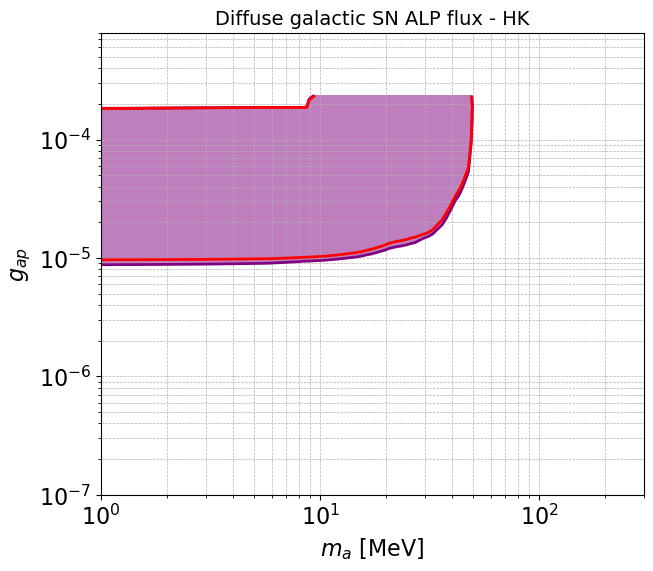

In [71]:
########
# Load #
########

data = np.loadtxt("tutorial_results/Z_KSVZ_diffuse_HK.txt")
X_loaded, Y_loaded, Z_loaded = data[:, 0], data[:, 1], data[:, 2]

# g_ap = C_ap * g_a
Y_loaded = Y_loaded *0.47


# make the mesh
x_unique = np.unique(X_loaded)
y_unique = np.unique(Y_loaded)

X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

Z_grid = np.zeros_like(X_grid)

# Z values
for i in range(len(X_loaded)):
    x_idx = np.where(x_unique == X_loaded[i])[0][0]
    y_idx = np.where(y_unique == Y_loaded[i])[0][0]
    Z_grid[y_idx, x_idx] = Z_loaded[i]

    
    

Z_level = 1.64
threshold = Z_level

# Plot
plt.figure(figsize=(7,6))

plt.contour(X_grid, Y_grid, Z_grid, levels=[threshold], colors='purple', linewidths=2, linestyles='-')
plt.contourf(X_grid, Y_grid, Z_grid, levels=[threshold, Z_loaded.max()], colors=["purple"], alpha=0.5)

plt.contour(X_grid, Y_grid, Z_grid, levels=[1.96], colors='red', linewidths=2, linestyles='-')

plt.xlim(1,3e2)
plt.ylim(1e-7,8e-4)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title("Diffuse galactic SN ALP flux - HK", fontsize= 14)
plt.xlabel(r"$m_a$ [MeV]", fontsize= 16)
plt.ylabel(r"$g_{ap}$", fontsize= 16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [72]:
#### PREVIOUS BOUNDS ####

# cooling bounds
datacool = np.loadtxt("../ExpData/gaN_bounds/cooling_bounds.dat")

macool = datacool[:,0] / 1.e6 # convert to MeV
gap_cool = datacool[:,1]  



# SNO bounds ma array
dataSNO = np.loadtxt("../ExpData/gaN_bounds/SNO_gap.txt")

maSNO = dataSNO[:,0] / 1.e6 # convert to MeV
gap_SNO = dataSNO[:,1]  

In [73]:
# FUNCTION TO LOAD ALL THE CONSTRAINTS

def load_and_prepare_grid(filename, y_scale=0.47):
    data = np.loadtxt(filename)
    # y_scale needed because    g_ap = C_ap * g_a
    X, Y, Z = data[:, 0], data[:, 1] * y_scale, data[:, 2]

    x_unique = np.unique(X)
    y_unique = np.unique(Y)
    X_grid, Y_grid = np.meshgrid(x_unique, y_unique)
    Z_grid = np.zeros_like(X_grid)

    for i in range(len(X)):
        x_idx = np.where(x_unique == X[i])[0][0]
        y_idx = np.where(y_unique == Y[i])[0][0]
        Z_grid[y_idx, x_idx] = Z[i]

    return X_grid, Y_grid, Z_grid

# Files
files = {
    "SKIV": "tutorial_results/Z_KSVZ_diffuse_4pi.txt",
    "HK": "tutorial_results/Z_KSVZ_diffuse_HK.txt"
}

# Diccionarios para guardar los resultados
grids = {}

for label, filepath in files.items():
    Xg, Yg, Zg = load_and_prepare_grid(filepath)
    grids[label] = {"X": Xg, "Y": Yg, "Z": Zg}

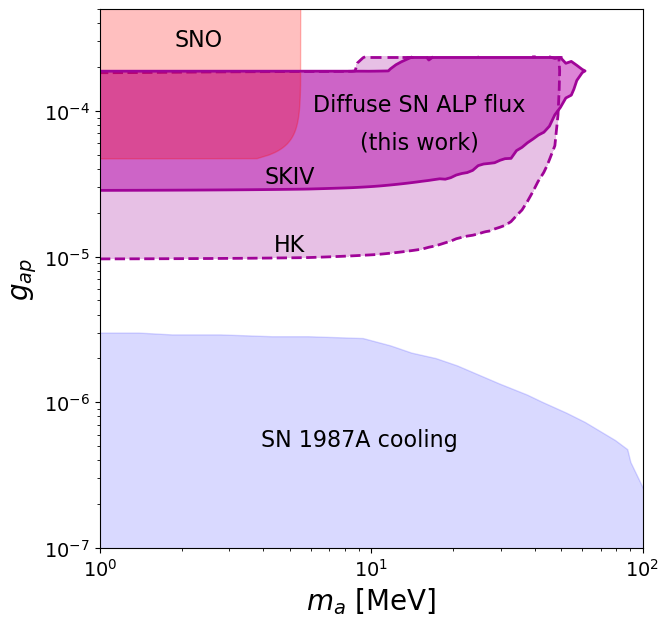

In [79]:
########
# PLOT #
########

# Z value to plot contour
Z_level = 1.96

# colors
colorfill = 'xkcd:lavender pink'
colorline = 'xkcd:barney purple'
colortext = 'black'


# PLOT
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)


# SK
ax.contour(grids["SKIV"]["X"], grids["SKIV"]["Y"], grids["SKIV"]["Z"], levels=[Z_level], colors=colorline, linewidths=2, linestyles='-')
ax.contourf(grids["SKIV"]["X"], grids["SKIV"]["Y"], grids["SKIV"]["Z"], levels=[Z_level, grids["SKIV"]["Z"].max()], colors=[colorfill], alpha=1)

# HK
ax.contour(grids["HK"]["X"], grids["HK"]["Y"], grids["HK"]["Z"], levels=[Z_level], colors=colorline, linewidths=2, linestyles='--', zorder=1)
ax.contourf(grids["HK"]["X"], grids["HK"]["Y"], grids["HK"]["Z"], levels=[Z_level, grids["HK"]["Z"].max()], colors=[colorline], alpha=0.25, zorder=1)



# OTHER BOUNDS
# Cooling bounds
ax.fill_between(macool, gap_cool, 1e-8, color='blue', alpha=0.15)

# SNO
ax.fill_between(maSNO, gap_SNO, color='red', alpha=0.25)


# cosmetic
ax.hlines(0.47*4.99e-4,13.47,50.47,color=colorline,linewidth=2)
ax.hlines(0.47*4.99e-4,9.9,10.9,color=colorline,linewidth=2)
ax.hlines(0.47*4.99e-4,11.4,12.5,color=colorline,linewidth=2)
ax.hlines(0.47*4.99e-4,13,14.25,color=colorline,linewidth=2, zorder=1)


# more text
ax.text(9e0, 5e-7, 'SN 1987A cooling', color='black', fontsize=16, rotation=0, ha='center')
ax.text(1.5e1, 10e-5, 'Diffuse SN ALP flux', color=colortext, fontsize=16, rotation=0, ha='center')
ax.text(5e0, 3.2e-5, 'SKIV', color=colortext, fontsize=16, rotation=0, ha='center')
ax.text(5e0, 1.1e-5, 'HK', color=colortext, fontsize=16, rotation=0, ha='center')
ax.text(2.3e0, 2.8e-4, 'SNO', color='black', fontsize=16, rotation=0, ha='center')


ax.set_xlabel('$m_a$ [MeV]', fontsize=20)
ax.set_ylabel('$g_{ap}$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e0, 1.e2)
ax.set_ylim(1e-7, 5e-4)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# plt.savefig("tutorial_results/boundsSK_g_vs_ma_SKIV_HK.pdf", bbox_inches='tight')
plt.show()